# Embedding Graph-Structured Data on Manifolds

## Introduction

From social networks to parse trees, knowledge graphs to protien interaction networks, Graph-Structured Data is endemic to a wide variety of natural and engineered systems. Often, understanding the structure and/or dynamics of these graphs yeilds insight into the systems under investigation. Take, for example, the problems of finding key influencers or distinct communities within social networks. 

The goal of graph embedding is to find a way of representing the graph in a space which more readily lends itself to analysis/investigation. One approach is to identify points in a vector space with nodes of the graph in such a way that important relations between nodes are preserved via relations between their corresponding points.

There are a wide variety of methods which approach this problem in different ways and for different aims, say for clustering or for link prediction. Recently, the embedding of Graph Structured Data (GSD) on manifolds has received considerable attention. In particular, much work has shown that hyperbolic spaces are beneficial for a wide variety of tasks with GSD. This tutorial shows how to learn such embeddings using the Poincaré Ball manifold and the well-known 'Karate Club' social network dataset with `geomstats`. This data and several others can be found in the `datasets.data` module of the project's github repository. 

![KarateEmbedding](figures/karate_embedding_iterations.gif "segment")
*Learning a Poincaré disk embedding of the Karate club graph dataset*

## Setup


We start by importing standard tools for logging and visualization, allowing us to draw the embedding of the GSD on the manifold. Next, we import the manifold of interest, visualization tools, and other methods from `geomstats`.

In [1]:
import logging
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.datasets.utils import load_karate
from geomstats.geometry.poincare_ball import PoincareBall

INFO: Using numpy backend


## Parameters and Initialization

We define the following parameters needed for embedding:

| Parameter | Description   |
|:------|:------|
|   random.seed  | An initial manually set number for generating pseudorandom numbers|
| dim | Dimensions of the manifold used for embedding |
|max_epochs|Number of iterations for learning the embedding |
|lr| Learning rate|
|n_negative| Number of negative samples|
|context_size| Size of the considered context for each node of the graph|

Let us discuss a few things about the parameters of the above table.
The number of dimensions should be high (i.e., 10+) for large datasets 
(i.e., where the number of nodes/edges is significantly large). 
In this tutorial we consider a dataset that is quite small with only 34 nodes. The Poincaré disk of only two dimensions is therefore sufficient to
capture the complexity of the graph and provide a faithful representation.
Some parameters are hard to know in advance, such as `max_epochs` and `lr`. These should be tuned specifically for each dataset.
Visualization can help with tuning the parameters. Also, one can perform a grid search to find values of these parameters which maximize some performance function. In learning embeddings, one can consider performance metrics such as
a measure for cluster seperability or normalized mutual 
information (NMI) or others.
Similarly, the number of negative samples and context size can also be thought of as hyperparameters and will
be further discussed in the sequel. An instance of the `Graph` class is created
 and set to the Karate club dataset.

In [2]:
gs.random.seed(1234)
dim = 2
max_epochs = 15
lr = .05
n_negative = 2
context_size = 1
karate_graph = load_karate()

The Zachary karate club network was collected from
the members of a university karate club by Wayne Zachary
in 1977. Each node represents a member of the club,
and each edge represents an undirected relation between
two members. An often discussed problem using this dataset
is to find the two groups of people into which the
karate club split after an argument between two teachers.
<img src="figures/karate_graph.png" width="60%">
Some information about the dataset is displayed to provide
insight into its complexity.

In [3]:
nb_vertices_by_edges =\
    [len(e_2) for _, e_2 in karate_graph.edges.items()]
logging.info('Number of edges: %s', len(karate_graph.edges))
logging.info(
    'Mean vertices by edges: %s',
    (sum(nb_vertices_by_edges, 0) / len(karate_graph.edges)))

INFO: Number of edges: 34
INFO: Mean vertices by edges: 4.588235294117647


Denote $V$ as the set of nodes and $E \subset V\times V$ the set 
of edges. The goal of embedding GSD is to provide a faithful and exploitable representation 
of the graph structure. It is mainly achieved by preserving  *first-order* proximity 
that enforces nodes sharing edges to be close to each other. It can additionally 
preserve *second-order* proximity that enforces two nodes sharing the same context 
(i.e., nodes that are neighbours but not necessarily directly connected) to be close. 
Let $\mathbb{B}^m$ be the Poincaré Ball of dimension $m$ equipped with the distance function $d$.
The below figure shows geodesics between pairs of points on $\mathbb{B}^2$. Geodesics are
the shortest path between two points. The distance function $d$ of two points is
the length of the geodesic that links them.

<img src="figures/geodesics.png" width="40%">


Declaring an instance of the `PoincareBall` manifold of two dimensions in `geomstats` is straightforward:

In [4]:
hyperbolic_manifold = PoincareBall(2)

*first* and *second-order* proximities can be achieved by optimising the following loss functions:

## Loss function.

To preserve first and second-order proximities we adopt a loss function similar to <cite data-cite="7875465/KRA9K53S"></cite> and consider the negative sampling approach as in <cite data-cite="7875465/9CMMEH2F"></cite> :

$$     \mathcal{L} = - \sum_{v_i\in V} \sum_{v_j \in C_i} \bigg[ log(\sigma(-d^2(\phi_i, \phi_j'))) + \sum_{v_k\sim \mathcal{P}_n} log(\sigma(d^2(\phi_i, \phi_k')))  \bigg]$$

where $\sigma(x)=\frac{1}{1+e^{-x}}$ is the sigmoid function and $\phi_i \in \mathbb{B}^m$ 
is the embedding of the $i$-th node of $V$, $C_i$ the nodes in the context of the 
$i$-th node, $\phi_j'\in \mathbb{B}^m$ the embedding of $v_j\in C_i$ and 
$\mathcal{P}_n$ the negative sampling distribution over $V$: 
$\mathcal{P}_n(v)=\frac{deg(v)^{3/4}}{\sum_{v_i\in V}deg(v_i)^{3/4}}$. 
Intuitively one can see that to minimizing $L$, the distance between $v_i$ and $v_j$ should get smaller, while the one between
$v_i$ and $v_k$ would get larger.
<img src="figures/Notations.png" width="40%">

## Riemannian optimization.
Following the idea of <cite data-cite="7875465/9DR2QEF9"></cite> we use the following formula to optimize $L$:

$$ \phi^{t+1} = \text{Exp}_{\phi^t} \left( -lr \frac{\partial L}{\partial \phi} \right) $$

where $\phi$ is a parameter of $L$, $t\in\{1,2,\cdots\}$ is the epoch iteration number 
and $lr$ is the learning rate. The formula consists of first computing the usual gradient of the loss function
giving the direction in which the parameter should move. 
The Riemannian exponential map $\text{Exp}$ is a function that takes a base point $\phi^t$ and some 
direction vector $T$ and returns the point $\phi^{t+1}$ such that $\phi^{t+1}$ belongs to the geodesic
initiated from $\phi{t}$ in the direction of $T$ and the length of the geoedesic curve between $\phi^t$ and $\phi^{t+1}$ is of 1 unit. 
The Riemannian exponential map is implemented as a method of the `PoincareBallMetric` class in the `geometry` module of `geomstats`.

Therefore to minimize $L$ we will need to compute its gradient. Several steps are required to do so,
1. Compute the gradient of the squared distance
2. Compute the gradient of the log sigmoid
3. Compute the gradient of the composision of 1. and 2.

For 1., we use the formula proposed by <cite data-cite="7875465/TLSACAEQ"></cite> which uses the Riemannian logarithmic map to compute the gradient of the distance. 
This is implemented as

In [5]:
def grad_squared_distance(point_a, point_b):
    """Gradient of squared hyperbolic distance.

    Gradient of the squared distance based on the
    Ball representation according to point_a

    Parameters
    ----------
    point_a : array-like, shape=[n_samples, dim]
        First point in hyperbolic space.
    point_b : array-like, shape=[n_samples, dim]
        Second point in hyperbolic space.

    Returns
    -------
    dist : array-like, shape=[n_samples, 1]
        Geodesic squared distance between the two points.
    """
    hyperbolic_metric = PoincareBall(2).metric
    log_map = hyperbolic_metric.log(point_b, point_a)

    return -2 * log_map

For 2. define the `log_sigmoid` corresponding as follows:

In [6]:
def log_sigmoid(vector):
    """Logsigmoid function.

    Apply log sigmoid function

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    result : array-like, shape=[n_samples, dim]
    """
    return gs.log((1 / (1 + gs.exp(-vector))))

The gradient of the logarithm of sigmoid function is implemented as:

In [7]:
def grad_log_sigmoid(vector):
    """Gradient of log sigmoid function.

    Parameters
    ----------
    vector : array-like, shape=[n_samples, dim]

    Returns
    -------
    gradient : array-like, shape=[n_samples, dim]
    """
    return 1 / (1 + gs.exp(vector))

For 3., apply the composition rule to obtain the gradient of $L$. The following function given $\phi_i$, $\phi'_j$ and $\phi'_k$ returns the total value of $L$ and its gradient vector at $\phi_i$. For the value of $L$ the loss function formula is simply applied. For the gradient, we apply the composition of `grad_log_sigmoid` with `grad_squared_distance` while paying attention to the signs.

In [8]:
def loss(example_embedding, context_embedding, negative_embedding,
         manifold):
    """Compute loss and grad.

    Compute loss and grad given embedding of the current example,
    embedding of the context and negative sampling embedding.
    """
    n_edges, dim =\
        negative_embedding.shape[0], example_embedding.shape[-1]
    example_embedding = gs.expand_dims(example_embedding, 0)
    context_embedding = gs.expand_dims(context_embedding, 0)
    positive_distance =\
        manifold.metric.squared_dist(
            example_embedding, context_embedding)
    positive_loss =\
        log_sigmoid(-positive_distance)

    reshaped_example_embedding =\
        gs.repeat(example_embedding, n_edges, axis=0)
    negative_distance =\
        manifold.metric.squared_dist(
            reshaped_example_embedding, negative_embedding)
    negative_loss = log_sigmoid(negative_distance)

    total_loss = -(positive_loss + negative_loss.sum())

    positive_log_sigmoid_grad =\
        -grad_log_sigmoid(-positive_distance)

    positive_distance_grad =\
        grad_squared_distance(example_embedding, context_embedding)

    positive_grad =\
        gs.repeat(positive_log_sigmoid_grad, dim, axis=-1)\
        * positive_distance_grad

    negative_distance_grad =\
        grad_squared_distance(reshaped_example_embedding, negative_embedding)

    negative_distance = gs.to_ndarray(negative_distance,
                                      to_ndim=2, axis=-1)
    negative_log_sigmoid_grad =\
        grad_log_sigmoid(negative_distance)

    negative_grad = negative_log_sigmoid_grad\
        * negative_distance_grad
    example_grad = -(positive_grad + negative_grad.sum(axis=0))

    return total_loss, example_grad

## Capturing the graph structure
At this point we have the necessary bricks to compute the resulting gradient of $L$. We are ready to prepare
the nodes $v_i$, $v_j$ and $v_k$ and initialise their embeddings $\phi_i$, $\phi^{'}_j$ and $\phi^{'}_k$.
First, initialize an array that will hold embeddings $\phi_i$ of each node $v_i\in V$ with random points belonging to the Poincaré disk. 

In [9]:
embeddings = gs.random.normal(size=(karate_graph.n_nodes, dim))
embeddings = embeddings * 0.2

Next, to prepare the context nodes $v_j$ for each node $v_i$, we compute random walks initialised from each $v_i$ 
up to some length (5 by default). The latter is done via a special function within the `Graph` class. The nodes $v_j$ will be later picked from the random walk of $v_i$.



In [10]:
random_walks = karate_graph.random_walk()

Negatively sampled nodes $v_k$ are chosen according to the previously defined probability distribution function
$\mathcal{P}_n(v_k)$ implemented as

In [11]:
negative_table_parameter = 5
negative_sampling_table = []

for i, nb_v in enumerate(nb_vertices_by_edges):
    negative_sampling_table +=\
        ([i] * int((nb_v**(3. / 4.))) * negative_table_parameter)

negative_sampling_table = gs.array(negative_sampling_table)

## Numerically optimizing the loss function
Optimising the loss function is performed numerically over the number of epochs. 
At each iteration, we will compute the gradient of $L$. Then the graph nodes are moved in the direction
pointed by the gradient. The movement of the nodes is performed by following geodesics in the gradient direction.
The key to obtain an embedding representing accurately the dataset, is to move the nodes smoothly rather
than brutal movements. This is done by tuning the learning rate, such as at each epoch
all the nodes made small movements.

A *first level* loop iterates over the epochs, the table `total_loss` will record the value of $L$ at each iteration
and help us track the minimization of $L$.

A *second level* nested loop iterates over each path in the previously computed random walks. Observing these walks, notice that nodes having 
many edges appear more often. Such nodes
can be considered as important crossroads and will therefore be subject to a greater number of embedding updates. 
This is one of the main reasons why random walks have proven to be effective
in capturing the structure of graphs. The context of each $v_i$ will be the set of nodes $v_j$ belonging 
to the random walk from $v_i$. The `context_size` specified earlier will limit the length of the walk to be considered. Similarly, we use
the same `context_size` to limit the number of negative samples. We find $\phi_i$ from the `embeddings` array.



A *third level* nested loop will iterate on each $v_j$ and $v_k$. From within, we find $\phi'_j$ and $\phi'_k$ then call the `loss` function to compute the gradient.
Then the Riemannian exponential map is applied to find the new value of $\phi_i$ as we mentioned before.

In [13]:
for epoch in range(max_epochs):
    total_loss = []
    for path in random_walks:

        for example_index, one_path in enumerate(path):
            context_index = path[max(0, example_index - context_size):
                                 min(example_index + context_size,
                                 len(path))]
            negative_index =\
                gs.random.randint(negative_sampling_table.shape[0],
                                  size=(len(context_index),
                                  n_negative))
            negative_index = negative_sampling_table[negative_index]

            example_embedding = embeddings[one_path]
            for one_context_i, one_negative_i in zip(context_index,
                                                     negative_index):
                context_embedding = embeddings[one_context_i]
                negative_embedding = embeddings[one_negative_i]
                l, g_ex = loss(
                    example_embedding,
                    context_embedding,
                    negative_embedding,
                    hyperbolic_manifold)
                total_loss.append(l)

                example_to_update = embeddings[one_path]
                embeddings[one_path] = hyperbolic_manifold.metric.exp(
                    -lr * g_ex, example_to_update)
    logging.info(
        'iteration %d loss_value %f',
        epoch, sum(total_loss, 0) / len(total_loss))

INFO: iteration 0 loss_value 1.398861
INFO: iteration 1 loss_value 1.372997
INFO: iteration 2 loss_value 1.383977
INFO: iteration 3 loss_value 1.345949
INFO: iteration 4 loss_value 1.371338
INFO: iteration 5 loss_value 1.371177
INFO: iteration 6 loss_value 1.378920
INFO: iteration 7 loss_value 1.354262
INFO: iteration 8 loss_value 1.318966
INFO: iteration 9 loss_value 1.316274


In [ ]:
def plot_x(x):
    fig, ax = plt.subplots(figsize=(10, 10))
    circle = pt.Circle((0, 0), 1, facecolor='none', edgecolor=(0, 0, 0), linewidth=3, alpha=0.5)
    ax.add_patch(circle)
    plt.scatter(x[0,:], x[1,:], s=1)
#     for i in np.random.choice(range(x.shape[1]), size = 20):
#         plt.text(x[0,i], x[1,i], df[df.ind == i].index[0], fontsize=9)
    
    for word, ind in syns_inds:
        row = df[df.ind == ind]
        name = row.index.values[0]
        level = row.level.values[0]
        label = str(level) + ': ' + name
        size = 15/(0.5*level+1)
        x0 = x[0,ind]
        x1 = x[1,ind]
        hypo_inds = row.numeric_synset.values
        if hypo_inds:
            for hypo_ind in hypo_inds[0]:
                child_x0 = x[0,hypo_ind]
                child_x1 = x[1,hypo_ind]
                ax.annotate("", xy=(x0, x1), xytext=(child_x0, child_x1), arrowprops=dict(arrowstyle="<-"))
        plt.text(x0, x1, label, fontsize=size)
    plt.title("Hyperbolic Embedding of WordNet Synsets in the Poincare Ball")
    plt.show()


## Plotting results
Once the `max_epochs` iterations of epochs is achieved, we can plot the resulting `embeddings` array and the true labels shown
as two colors. At 15 epochs we can see that the two group of nodes with different labels are moving away from each other
on the manifold. If one increases the `max_epochs`, then further seperability is achieved.

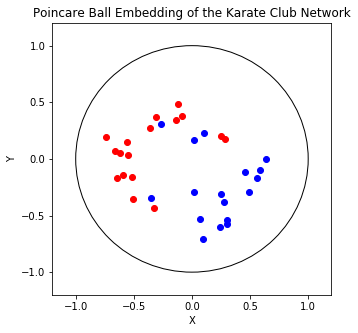

In [36]:
colors = {1: 'b', 2: 'r'}
circle = visualization.PoincareDisk(point_type='ball')
fig, ax = plt.subplots(figsize=(5, 5))
circle.set_ax(ax)
circle.draw(ax=ax)

for i_embedding, embedding in enumerate(embeddings):
    plt.scatter(
        embedding[0], embedding[1],
        c=colors[karate_graph.labels[i_embedding][0]])
    
plt.title('Poincare Ball Embedding of the Karate Club Network')
plt.show()

## References
<div class="cite2c-biblio"></div>